Técnicas de reducción de dimensionalidad
===================================

## Introducción

Topic modeling es una técnica de aprendizaje automático no supervisado donde intentados descubrir tópicos que son abstractos al texto pero que pueden describir una colección de documentos. Es importante marcar que estos "tópicos" no son necesariamente equivalentes a la interpretación coloquial de tópicos, sino que responden a un patrón que emerge de las palabras que están en los documentos.

La suposición básica para Topic Modeling es que cada documento está representado por una mescla de tópicos, y cada tópico consiste en una colección de palabras.

### Para ejecutar este notebook

Para ejecutar este notebook, instalaremos las siguientes librerias:

```
nltk
pandas
numpy
matplotlib
tqdm
spacy==2.3.5
unidecode
scikit-learn
importlib-metadata==4.13.0
pyLDAvis
```

In [ ]:
!wget https://raw.githubusercontent.com/santiagxf/M72109/master/NLP/Datasets/mascorpus/tweets_marketing.csv \
    --quiet --no-clobber --directory-prefix ./Datasets/mascorpus/

!wget https://raw.githubusercontent.com/santiagxf/M72109/master/docs/nlp/classic/topic-modeling.txt \
    --quiet --no-clobber
!pip install -r topic-modeling.txt --quiet

In [2]:
!python -m spacy download es_core_news_sm 1> /dev/null

Deshabilitamos algunos mensajes de advertencias:

In [17]:
import warnings
warnings.filterwarnings("ignore")

Primero importaremos algunas librerias necesarias

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Sobre el set de datos con el que vamos a trabajar

Utilizaremos como ejemplo un set de datos en español que contiene tweets que diferentes usuarios han publicado en relación a diferentes marcas de productos u empresas en el rubro de alimentación, construcción, automoviles, etc. Estos tweets, a su vez, están asociados a una de las diferentes fases en el proceso de ventas (también conocido como Marketing Funel) y por eso están tagueados con las fases de:

 - Awareness – el cliente es conciente de la existencia de un producto o servicio
 - Interest – activamente expresa el interes de un producto o servicio
 - Evaluation – aspira una marca o producto en particular
 - Purchase – toma el siguiente paso necesario para comprar el producto o servicio
 - Postpurchase - realización del proceso de compra. El cliente compara la diferencia entre lo que deseaba y lo que obtuvo

Referencia: [Spanish Corpus of Tweets for Marketing](http://ceur-ws.org/Vol-2111/paper1.pdf

> Nota: La version de este conjunto de datos que utilizaremos aqui es una versión preprocesada del original.

In [5]:
tweets = pd.read_csv('Datasets/mascorpus/tweets_marketing.csv')

Inspeccionamos el set de datos

In [6]:
tweets.head(5)

,TEXTO,SECTOR,MARCA,CANAL,AWARENESS,EVALUATION,PURCHASE,POSTPURCHASE,NC2
0,#tablondeanuncios Funda nordica ikea #madrid h...,RETAIL,IKEA,Microblog,0,0,0.0,0,1.0
1,#tr Me ofrezco para montar muebles de Ikea - H...,RETAIL,IKEA,Microblog,0,0,0.0,0,1.0
2,#VozPópuli Vozpópuli @voz_populi - #LoMásLeido...,RETAIL,ALCAMPO,Microblog,0,0,0.0,0,1.0
3,#ZonaTecno Destacado: Todo lo que hay que sabe...,RETAIL,CARREFOUR,Microblog,0,0,0.0,0,1.0
4,$Carrefour retira pez #Panga. OCU y grupos x #...,RETAIL,CARREFOUR,Microblog,0,0,0.0,0,1.0


In [7]:
tweets.groupby('SECTOR').head(1)[['TEXTO', 'SECTOR']]

,TEXTO,SECTOR
0,#tablondeanuncios Funda nordica ikea #madrid h...,RETAIL
725,"""Ilcinsisti lis MB dispiniblis"" te odeeeeeo Mo...",TELCO
964,#CarlosSlim y Bimbo lanzarán un vehículo eléct...,ALIMENTACION
1298,"‼🏎Toyota #Day, 4ruedas ,1/4 milla, 1 #pasión, ...",AUTOMOCION
1748,"""- Tú qué.\n- Yo na.""\nConversaciones banco sa...",BANCA
2348,"- Cariño, te juro que sólo tenían Cruzcampo en...",BEBIDAS
3023,#adidas #hockey Amenabar 2080 CABA https://t.c...,DEPORTES


## Preprosesamiento

Como en toda tarea de NLP, y más generalmente, en Machine Learning, ocuparemos una porción de nuestro tiempo en preprocesar los datos para generar representaciones útiles y deshacernos de problemas especificos que podría exhibir nuestro set de datos.

### Creando una rutina de preprosesamiento de texto

Realizaremos las tareas cotidianas de preprocesamiento. Adicionalmente nuestra rutina va a:

 - Eliminar caracteres especiales: Acentos y caracteres especiales podrían complejizar el la representación de palabras, por lo que los eliminaremos.
 - Eliminaremos URLs y handles que son típicos en tweeter. Esto es especifico en este set de datos ya que una URL no representa información en este contexto.

In [8]:
import unidecode
import spacy
import es_core_news_sm as spa
import re
import nltk
from nltk import stem
from nltk.corpus import stopwords
from nltk.tokenize.casual import TweetTokenizer

nltk.download('stopwords', quiet=True)

parser = spa.load() # Cargamos el parser en español
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True) # Creamos un tokenizer
stemmer = stem.SnowballStemmer(language='spanish') # Creamos un steammer
lemmatizer = lambda word : " ".join([token.lemma_ for token in parser(word)]) # Creamos un lemmatizer
stopwords = set(stopwords.words('spanish')) # Instanciamos las stopwords en español
urls_regex = re.compile(r'http\S+') # Usamos una expresion regular para encontrar las URLs

def process_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token for token in tokens if not re.match(urls_regex, token)]
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in stopwords]
    tokens = [unidecode.unidecode(token) for token in tokens] # Quitamos acentos
    tokens = [lemmatizer(token) for token in tokens]
    return tokens

In [9]:
doc_list = []

for doc in tqdm(tweets['TEXTO']):
    tokens = process_text(doc)
    doc_list.append(' '.join(tokens))

100%|██████████| 3763/3763 [02:18<00:00, 27.21it/s]


Revisemos algunos resultados:

In [18]:
tweets['TEXTO'][2]

'#VozPópuli Vozpópuli @voz_populi - #LoMásLeidoHoy Mercadona, DIA o Alcampo guardan silencio ante la ola europea... https://t.co/aJTuA4J9UV'

In [11]:
doc_list[2]

'# vozpopuli Vozpopuli # lomasleidohoy Mercadona Alcampo guardar silencio europeo'

In [15]:
len(doc_list)

3763

## Vectorización

Una vez que nuesto texto fue preprocesado para mantener solo aquellas palabras que nos son relevantes, pasamos al proceso de generar vectores a partir de las palabras que componen nuestro vocabulario. Nuestros modelos no pueden operar sobre palabras, y por lo tanto necesitamos una representación númerica de las mismas.

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True, sublinear_tf=True, norm='l2')
vectors = np.asarray(vectorizer.fit_transform(doc_list).todense())

In [21]:
vectors.shape

(3763, 6924)

## Reducción de dimensionalidad: Featurization
Una vez que tenemos nuestros palabras representadas como vectores, nos aparece el problema de que ¡aún son demasiado grandes! En el ejemplo anterior, estamos trabajando con vectores en un espacio de 6K+. Necesitamos reducir esta dimensionalidad. Para esto, utilizaremos métodos de reducción de dimensionalidad con el objetivo de generar features que nos sean más utiles. Estas features las generaremos de forma "no supervisada"

### Métodos básados en descomposición de matrices

Los modelos basados en factorización de matrices intentan reducir la dimensionalidad de la matriz al aproximarla usando dos matrices que representan embeddings de palabras y embeddings de documentos (más una matriz singular que los vincula los unos con los otros). Este método es bastante popular no solo en NLP sino que también en sistemas de recomendación, método que fué ganador del Netflix Prize (Funk SVD).

<img src="https://miro.medium.com/max/700/1*Z0EUVs7QElEqRqXtqut_FQ.png" />


U y V(trapuesta) son ortogonales. Esto es de esperar porque si determinadas propiedades determinan un determinado factor latente, entonces esas propiedades serán poco relevantes en los restantes factores (pues sino, no haría sentido que conformen un factor distinto en un primer lugar).

SVC es un metodo de decomposición exacto, lo que singnifica que las matrices U y V son lo suficientemente grandes para mapear exactamente la matriz A.

### LSI - Latent Semantic Indexing

LSI es un caso particular de factorización de matrices. Cuando SVD es utilizado para procesar tópicos en texto y en donde los valores de la matriz A corresponden a frecuencias de palabras, este método se lo denomina Latent Semantic Analysis (sin embargo, en NLP no se lo suele nombrar como LSI).

Dado que SVC es un método de decomposición exacto, tiende a producir matrices de poca densidad (sparse). Para evitar este problema, se utiliza una versión modificada de SVC conocida como Truncated SVD que solamente computa los k componentes mas grandes en la descomposición. Esto ayuda a que LSI combata efectivamente el problema de matrices sparse que tienden a generarse cuando se tienen cuerpos de texto con sinónimos y palabras que significan varias cosas dependiendo del contexto. Truncated SVD evíta ser un método de decomposición exacto al aproximar la matriz A utilizando los k tópicos más relevantes.

<img src='https://github.com/fastai/course-nlp/raw/aabfeddf61fea29b18c72f841d057b56a216b7eb/images/svd_fb.png' />

Facebook Research: Fast Randomized SVD [https://research.fb.com/fast-randomized-svd/])

En esta configuración entonces:
 - Un documento es nada mas que la distribución de palabras que ocurren en el (Bag of words)
 - A es una matriz de m x n donde m es la cantidad de documentos ú observaciones, y n es la cantidad de palabras en el vocabulario.
 - Los valores de A corresponden a la frecuencia de la cada palabra del vocabulario en cada observación ú documento.
 - A es una matriz sujeta a ruido con distribución Gausiana.


Referencia: Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions [https://arxiv.org/abs/0909.4061]

El principal parametro en LSI es el numero de factores que queremos generar (el parametro K). No existe una regla para especificar este parametro ya que depende del escenario. Valores muy pequeños pueden forzar a los documentos a ser colisionar en los tópicos que son asignados, mientras que valores muy grandes pueden hacer que palabras poco frecuentes y raras terminen determinando su propio "topico".

> Valores típicos de este parámetro están en 50 < k < 300

En la librería `scikit-learn`, este valor lo especificaremos en `n_components`. El parametro `algorithm` hace referencia al método que utilizaremos para generar la descomposición:

In [22]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=7, algorithm='randomized')

USigma = svd.fit_transform(vectors)
Sigma = svd.singular_values_
VT = svd.components_

Si bien en el codigo anterior estamos viendo las 3 matrices, solo nos interesa la matriz VT. ¿Porque? Recuerden que nuestro "input" es un conjunto de palabras que luego vectorizamos utilizando TF-IDF. Cada documento está representado por este conjunto de palabras. Nuestro objetivo es disponer una forma donde podamos convertir este set de palabras a "tópicos" que sean más informativos que las palabras propiamente dichas. **En consecuencia, lo único que nos interesa aqui es la matriz VT**

In [23]:
VT.shape

(7, 6924)

Internamente, TrucatedSVC es un wrapper de la clase randomized_svd donde la matríz Q que vimos anteriormente se genera a través de un método de sampling aleatorio. Las siguientes lineas son equivalentes a lo que vimos anteriormente:

In [ ]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(vectors,
                              n_components=7,
                              n_iter=5)

Podemos validar que U es una matriz ortogonal

In [ ]:
np.allclose(U.T @ U, np.eye(U.shape[1]))

True

Lo siguiente es solo a titulo informativo, pero si vemos los valores de la matriz Sigma, veremos la importancia relativa de los documentos con respecto a los tópicos que encontramos. Si los gráficamos vemos que sus valores comienzan a decrecer relativamente rápido, sosteniendo la supoción de que Truncated SVD genera los K más relevantes tópicos.

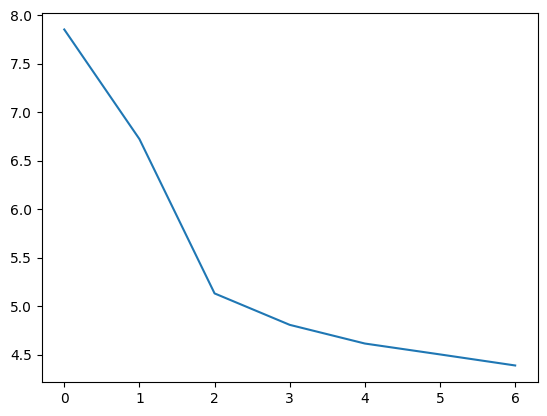

In [ ]:
plt.plot(Sigma)

#### Interpretando los tópicos


La siguiente función solo toma la matriz de VT y obtiene las 8 palabras más importantes en este topico. Si quieren pueden variar este parametro para ver más palabras e inspeccionar los tópicos. Esto es importante porque LSI es un método no supervisado, por lo tanto no sabemos a priori cuando un tópico es bueno o malo. El sentido debemos darselo nosotros:

In [ ]:
vocab = {value:key for (key, value) in vectorizer.vocabulary_.items()}

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[-8:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [ ]:
show_topics(VT)

['siempre anuncio superstar zapatilla aldub81stweeksary nuevo camiseta',
 'necesitar gustar gana querer medalla cerveza corona',
 '50 10 terminar carrera ritmo correr acabo',
 'cruzcampir gracias bimbo movistar mejor carrefour cruzcampo',
 'mahou invitar estrella gustar arruinaunacitacon4palabra cruzcampir cerveza',
 'cruzcampir comer gustar fundador lorenzo servitje osito',
 'querer mejor alianza suzuki milko toyota movistar']

Limitaciones en LSI:
 - LSI sufre de un problema llamado "Indeterminación del signo", que básicamente significa que el signo en la matríz VT y USigma dependen del algorimo que se utilizó para generarlos y de las condiciones iniciales (initial random state). En este contexto, que significa que un tópico esté relacionado con una palabra en un valor negativo?

### NMF: Non-negative Matrix Factorization

Motivación: En lugar de construir nuestros factores imponiendo la restricción de que sean ortogonales, la idea es de construirlos de tal forma que sean no-negativos.

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=7, random_state = 1234)

In [ ]:
W1 = nmf.fit_transform(vectors)
H1 = nmf.components_

En este caso, la matriz que nos interesa es H1

In [ ]:
H1.shape

(7, 6899)

#### Interpretando los tópicos

In [ ]:
show_topics(H1)

['siempre anuncio superstar zapatilla nuevo aldub81stweeksary camiseta',
 'tomar necesitar querer gana cerveza medalla corona',
 '50 10 terminar carrera ritmo correr acabo',
 'carne alcampo comprar vender mejor manán gracias',
 'galicia mejor estrella arruinaunacitacon4palabra gustar cruzcampir cerveza',
 'grupo gustar comer fundador lorenzo servitje osito',
 'gracias él poder mejor toyota milko movistar']

### LDA: Latent Dirichlet Allocation

LDA es un método Bayesiano basado en la distribución de Dirichlet, la cual es una distribución sobre probabilidades en K categorias. LDA supone que los documentos que tenemos pertenecen a K categorias distintas cuya distribución es desconocida, sin embargo, asume que todos los fragmentos que componen el texto fueron generados a través de un mismo proceso generativo.

La distribución Dirichlet es una generalización de la distribución Beta en un espacio multidimensional. Así como la distribución beta es la distribución previa de la binomial, la distribución de Dirichlet es la distribución previa de la multinomial.

$$ P(w\mid d) = P(d)\sum_c P(k\mid d)P(w\mid k) $$

*¿Notan alguna similitud con SVD?*

[David Blei, Andrew Ng, Michael Jordan: Latent Dirichlet Allocation (https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=7)

In [ ]:
lda.fit(vectors)

LatentDirichletAllocation(n_components=7)

#### Interpretando los tópicos

Podemos ver las 10 palabras más relevantes de los 7 tópicos que encontró LDA de la siguiente forma:

In [ ]:
for idx, topic in enumerate(lda.components_):
    print ("Topic ", idx, " ".join(vocab[i] for i in topic.argsort()[:-10 - 1:-1]))

Topic  0 toyota heineken movistar suzuki carrefour cruzcampir mejor alianza necesitar tener
Topic  1 bimbo mueble adidas bankia adida cliente montar carrefour mercadona amigo
Topic  2 heineken milko él mercadona santander gana quiero favor carrefour banco
Topic  3 adida mercadona camiseta cruzcampo cerveza hombre color estrella galicia nuevo
Topic  4 heineken gracias gustar movistar siempre querer peugeot corona quedar mercadona
Topic  5 acabo nikeplus correr adida ritmo heineken mejor milka refugiado mercadona
Topic  6 cruzcampo bimbo chocolate adida poder banco bankia querer patrocinado heineken


Otra alternativa es utilizando una librería especifica para estas visualizaciones. `pyLDAvis` es una librería de Python para la visualización de modelos de modelado de tópicos. Se trata de una portabilidad del fabuloso paquete de R de Carson Sievert y Kenny Shirley.

`pyLDAvis` está diseñada para ayudar a los usuarios a interpretar los temas en un modelo de tópicos que se ha ajustado a un corpus de datos de texto. El paquete extrae información de un modelo LDA.

La visualización está diseñada para usarse dentro de un notebook de Jupyter, pero también se puede guardar en un archivo HTML independiente para compartirlo fácilmente.

In [ ]:
import pyLDAvis
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


> Nota: la siguiente celda corrije un error en la libraría `pyLDAvis` en las ultimas versiones de `scikit-learn`. Puede omitir los detalles.

In [ ]:
pyLDAvis.lda_model._get_doc_lengths = lambda dtm: dtm.sum(axis=1).ravel()
pyLDAvis.lda_model._get_term_freqs = lambda dtm: dtm.sum(axis=0).ravel()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<module 'pyLDAvis.lda_model' from '/usr/local/lib/python3.10/dist-packages/pyLDAvis/lda_model.py'>

In [ ]:
pyLDAvis.lda_model.prepare(lda, vectors, vectorizer, mds='tsne')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0       73.242546   10.512508       1        1  15.729860
4     -135.212036  -19.932354       2        1  15.433575
2        8.827081   93.134766       3        1  14.480544
1       34.502068  -87.146095       4        1  14.194946
3      -30.950050   -4.515550       5        1  14.092400
5      -95.510620   77.838768       6        1  13.769977
6      -69.408546 -102.083939       7        1  12.298696, topic_info=           Term       Freq      Total Category  logprob  loglift
336       adida  59.000000  59.000000  Default  30.0000  30.0000
4534   nikeplus   9.000000   9.000000  Default  29.0000  29.0000
1895     correr   9.000000   9.000000  Default  28.0000  28.0000
267       acabo  11.000000  11.000000  Default  27.0000  27.0000
6212     suzuki   9.000000   9.000000  Default  26.0000  26.0000
...         ...        ...        ...      ...      ...      ...
3283   heineken   2.331148  58.332809   Topic7  -6.0977  -1.1241
4194      mejor   1.883641  20.082832   Topic7  -6.3108  -0.2710
1315  carrefour   1.898977  29.115251   Topic7  -6.3027  -0.6343
4743      pagar   1.563327   7.003053   Topic7  -6.4972   0.5961
6898         él   1.597090  19.333292   Topic7  -6.4758  -0.3980

[455 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
42        7  0.660624   10800
50        2  0.934872   11780
76        5  0.704733  160mil
107       6  0.639032      23
226       5  0.835984      95
...     ...       ...     ...
6898      3  0.362070      él
6898      4  0.051724      él
6898      5  0.051724      él
6898      6  0.155173      él
6898      7  0.103448      él

[730 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4, 6, 7])

Para más informacións sobre la librería `pyLDAvis`, se recomienda la lectura [del papaer original](http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) el cual fué presentado en la conferencia [*ACL Workshop on Interactive Language Learning, Visualization, and Interfaces*](http://nlp.stanford.edu/events/illvi2014/) en Baltimore el June 27, 2014.